<center><img src="https://pure.ups.edu.ec/skin/headerImage/" width="300" height="300"></center>

<h1><center>Universidad Politecnica Salesiana</center></h1>
<h2><center>Simulacion Simpy Vacunas</center></h2>


<b>Nombre: </b> Javier Vazquez

<b>Materia: </b> Simulacion


In [1]:
import simpy
import random
import datetime as dt
from datetime import datetime

### Variables de Interes

En este caso hemos decidido utilizar las siguientes variables de interes
* <b>Mesas Vacunacion: </b> seran las mesas con las que cuenta el recinto para realizar el proceso de vacunacion
* <b>Tiempo simulacion: </b>  tiempo que se tardara la simulacion 
* <b>Intervalo Llegada: </b> intervalo en la que se genera una nueva persona dentro de la simulacion 
* <b>Tiempo Vacunacion: </b> tiempo minimo que tarda en vacunar a una persona
* <b>Tiempo espera sintomas: </b> tiempo de que espera una persona despues de ser vacunado para verificar que no tenga problemas de salud
* <b>Tiempo certificado: </b>  tiempo minimo en entregar el certificado de vacunacion a la persona'
* <b>Cola: </b> numero de personas generadas a que formen cola para recibir la vacuna 
* <b>Porcentaje proceso ecuador: </b> del total de la poblacion que existe en ecuador, porcentaje que se prevee asista al proceso de vacunacion 
* <b>Porcentaje no vacunar: </b>  porcentaje de las personas que acuden al proceso no pueden vacunarse por algun problema de salud 
* <b>Estado personas: </b>  guardar el estado de todas las personas(no proceso, cola, espera, vacunado, espera, carnet, no califica)
* <b>Tiempos espera final: </b>  tiempo de espera cada persona en la cola hasta ser atendido por una mesa 
* <b>Tiempos vacunacion final: </b> tiempo en vacunarse cada persona
* <b>Mesas libres vacunacion: </b> comprobar si una mesa se encuentra libre para aceptar nueva persona se vacune

In [16]:
MESAS_VACUNACION=5 
TIEMPO_SIMULACION=500
INTERVALO_LLEGADA=5
TIEMPO_VACUNACION=5
TIEMPO_ESPERAR_SINTOMAS=20
TIEMPO_CERTIFICADO=2
COLA=10
PORCENTAJE_PROCESO_ECUADOR=80 
PORCENTAJE_NO_VACUNAR=10
estado_personas={} 
tiempos_espera={} 
tiempo_vacunacion_final={} 
tiempo_espera_final={}
MESAS_LIBRES_VACUNACION={}

### Variables Auxiliares
* personas vacunacion
* personas espera
* personas carnet

In [17]:
personas_vacunacion={}
personas_espera={}
personas_carnet={}
SEGUNDA_DOSIS= datetime.now().strftime('%d/%m/%Y')
for i in range(MESAS_VACUNACION):
    MESAS_LIBRES_VACUNACION[i]='Libre'

### Desarrollo de clases

Para esta simulacion unicamente se cuenta con la clase:
* <b>Vacunacion </b> En la cual contiene los metodos respectivos a cada uno de la fases de la vacunacion como proceso vacunaciopn, comprobar si una mesa se encuentra libre, el proceso de esperar a posibles problemas de salud despues de recibir la vacuna y la entrega del carnet. <br>
Cuando una persona pasa por cada uno de esos procesos automaticamente se van cambiando los estados en los cuales se encuentra la persona dentro del proceso de vacunacion 


In [18]:
class Vacunacion(object):
    
    def __init__(self, environment, mesas_vacunacion):
        self.env= environment
        self.mesas_vacunacion = simpy.Resource(environment, mesas_vacunacion)
        
    def proceso_vacunacion(self, nombre, tiempo, idMesa):
        yield self.env.timeout(random.randint(tiempo, tiempo+5))
        estado_personas[nombre]='Vacunado'
        MESAS_LIBRES_VACUNACION[idMesa]='Libre'
        
    def mesas_libres_vacunacion(self, num_mesa):
        if MESAS_LIBRES_VACUNACION.get(num_mesa) =='Libre':
            return True
        else:
            return False
        
    def proceso_esperar(self,nombre, tiempo):
        yield self.env.timeout(tiempo)
        estado_personas[nombre]='Espera_sintomas'
    
    def entrega_carnet(self, nombre, tiempo):
        yield self.env.timeout(tiempo)
        estado_personas[nombre]='Carnet'
        
    def salir_recinto(self):
        yield self.env.timeout(random.randint(1,5))
    def vaciar_mesas(self):
        for i in range(MESAS_VACUNACION):
            MESAS_LIBRES_VACUNACION[i]='Libre'

### Desarrollo logica de la simulacion 

In [19]:


def llegada_personas(env, nombre, vacunacion, tiempo_vacunacion, tiempo_espera, tiempo_certificado):
    
    if random.randint(1,100)>=(100-PORCENTAJE_PROCESO_ECUADOR):
        print('---> Genera [%s] a la cola hora %.2f.'%(nombre,env.now))
        if random.randint(1,100)<=PORCENTAJE_NO_VACUNAR:
            print('❌'*3,'[%s] acude al proceso pero no puede vacunarse  '%(nombre),'❌'*3)
            estado_personas[nombre]='No califica'
        else:
            estado_personas[nombre]='Cola'
            llegada=env.now
            tiempos_espera[nombre]=env.now
            with vacunacion.mesas_vacunacion.request() as mesas:
                yield mesas
                lista_cola=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Cola']
                for i in range(MESAS_VACUNACION):
                    if len(lista_cola)>0:
                        persona_cola=lista_cola[0]
                        if vacunacion.mesas_libres_vacunacion(i):
                            if not persona_cola in personas_vacunacion:
                                MESAS_LIBRES_VACUNACION[i]='Ocupada'
                                personas_vacunacion[persona_cola]=i
                                inicio_vacunacion=env.now
                                print('💉 La: [%s] entra a vacunarse al hora %.2f MESA %s luego de esperar  %s minutos '%(persona_cola,env.now, i+1, env.now-tiempos_espera[persona_cola]))
                                tiempo_espera_final[persona_cola]=env.now-tiempos_espera[persona_cola]
                                yield env.process(vacunacion.proceso_vacunacion(persona_cola, tiempo_vacunacion,i))
                                print('Sale de vacunarse [%s] a la hora %.2f libre MESA %s se demoro %s minutos'%(persona_cola, env.now, i+1, env.now-inicio_vacunacion))
                                tiempo_vacunacion_final[persona_cola]=env.now-inicio_vacunacion
                        lista_cola.remove(persona_cola)
                lista_vacuna=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Vacunado']
                for i in lista_vacuna:
                    if not i in personas_espera:
                        print('⌛ La: [%s] entra a la sala de espera al hora %.2f '%(i, env.now))
                        personas_espera[i]='espera'
                        yield env.process(vacunacion.proceso_esperar(i,tiempo_espera))
                        #print(' **** La: [%s] sale de sala de espera al hora %.2f '%(i, env.now))
                lista_espera=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Espera_sintomas']
                for i in lista_espera:
                    if not i in personas_carnet:
                        prox_cita = datetime.strftime(datetime.strptime(SEGUNDA_DOSIS, '%d/%m/%Y')+dt.timedelta(days=21), '%d/%m/%Y')
                        personas_carnet[i]='carnet'
                        yield env.process(vacunacion.entrega_carnet(i,tiempo_certificado))
                        print('📝 La: [%s] recibe su carnet al hora %.2f con fecha para segunda dosis %s'%(i, env.now, prox_cita))
                        
                        yield env.process(vacunacion.salir_recinto())
                        print('<<--- La: [%s] abandona las instalaciones al hora %.2f '%(i, env.now))
        
    else:
        print('---> Genera [%s] hora %.2f. no realiza proceso ☠️'%(nombre,env.now))
        estado_personas[nombre]='No proceso'
    

### Ejecutar Simulacion

In [20]:
def ejecutar_simulacion(env, mesas_vacunacion, intervalo_llegada, tiempo_vacunacion, tiempo_espera,tiempo_certificado):
    vacunacion = Vacunacion(env, mesas_vacunacion)
    i=0
    for j in range(COLA):
        env.process(llegada_personas(env,'Persona-%d'%(i+1), vacunacion,  tiempo_vacunacion, tiempo_espera, tiempo_certificado))
        i+=1
    while True:
        i+=1
        yield env.timeout(random.randint(intervalo_llegada-2, intervalo_llegada+2))
        env.process(llegada_personas(env,'Persona-%d'%(i), vacunacion,  tiempo_vacunacion, tiempo_espera, tiempo_certificado))
        
random.seed(77)
env= simpy.Environment()
env.process(ejecutar_simulacion(env, MESAS_VACUNACION,INTERVALO_LLEGADA, TIEMPO_VACUNACION, TIEMPO_ESPERAR_SINTOMAS, TIEMPO_CERTIFICADO))
env.run(until=TIEMPO_SIMULACION)

---> Genera [Persona-1] a la cola hora 0.00.
---> Genera [Persona-2] a la cola hora 0.00.
---> Genera [Persona-3] hora 0.00. no realiza proceso ☠️
---> Genera [Persona-4] a la cola hora 0.00.
---> Genera [Persona-5] a la cola hora 0.00.
---> Genera [Persona-6] a la cola hora 0.00.
---> Genera [Persona-7] a la cola hora 0.00.
---> Genera [Persona-8] a la cola hora 0.00.
---> Genera [Persona-9] hora 0.00. no realiza proceso ☠️
---> Genera [Persona-10] a la cola hora 0.00.
❌❌❌ [Persona-10] acude al proceso pero no puede vacunarse   ❌❌❌
💉 La: [Persona-1] entra a vacunarse al hora 0.00 MESA 1 luego de esperar  0 minutos 
💉 La: [Persona-2] entra a vacunarse al hora 0.00 MESA 2 luego de esperar  0 minutos 
💉 La: [Persona-4] entra a vacunarse al hora 0.00 MESA 3 luego de esperar  0 minutos 
💉 La: [Persona-5] entra a vacunarse al hora 0.00 MESA 4 luego de esperar  0 minutos 
💉 La: [Persona-6] entra a vacunarse al hora 0.00 MESA 5 luego de esperar  0 minutos 
---> Genera [Persona-11] a la cola h

### Resultados 

In [21]:
vacunados=0
proceso=0
no_atendidos=0
no_proceso=0
cola=0
for key in estado_personas:
    if estado_personas[key]=='Carnet': vacunados+=1
    if estado_personas[key]=='No proceso': no_proceso+=1
    if estado_personas[key]=='No califica': no_atendidos+=1
    if estado_personas[key]=='Cola': cola+=1
    if estado_personas[key]=='Carnet' or estado_personas[key]=='No califica' or estado_personas[key]=='Cola':  proceso+=1
print('-'*70,'\n* Total personas Generadas: ', len(estado_personas))
print('* Personas que asistieron al proceso: ', proceso)
print('* Personas que no asistieron al proceso: ', no_proceso)
print('* Personas que no pudieron vacunarse: ', no_atendidos)
print('* Personas que se vacunaron: ', vacunados)
print('* Personas que aun se encuentran en cola: ', cola)
print('* Tiempo promedio espera en la cola a ser atendido: ',sum(list(tiempo_espera_final.values()))/len(tiempo_espera_final),'\n','-'*70)

---------------------------------------------------------------------- 
* Total personas Generadas:  108
* Personas que asistieron al proceso:  84
* Personas que no asistieron al proceso:  20
* Personas que no pudieron vacunarse:  9
* Personas que se vacunaron:  70
* Personas que aun se encuentran en cola:  5
* Tiempo promedio espera en la cola a ser atendido:  8.631578947368421 
 ----------------------------------------------------------------------


## Graficas Primera Dosis

### Tiempo Espera en la cola

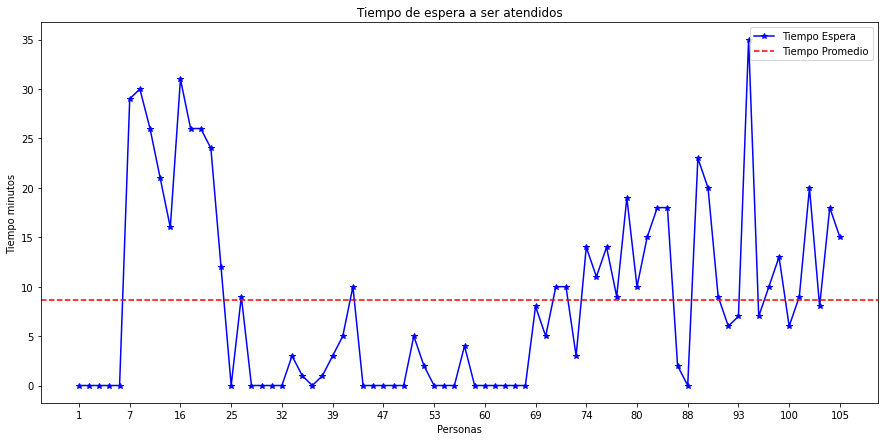

In [22]:
import matplotlib.pyplot as plt

promedio={}
for i in list(tiempo_espera_final.keys()):
    #print(i.split('-'))
    promedio[i.split('-')[1]]=tiempo_espera_final[i]


plt.figure(figsize = (15,7))
plt.plot(list(promedio.keys()),list(promedio.values()),'*-b')
plt.xticks(list(promedio.keys())[::5])
plt.axhline(y=sum(list(tiempo_espera_final.values()))/len(tiempo_espera_final), xmin=0.0, xmax=1,color='red',linestyle="--")

plt.title('Tiempo de espera a ser atendidos')
plt.xlabel('Personas')
plt.ylabel('Tiempo minutos')
plt.legend(['Tiempo Espera','Tiempo Promedio'])

### Tiempo vacunacion personas

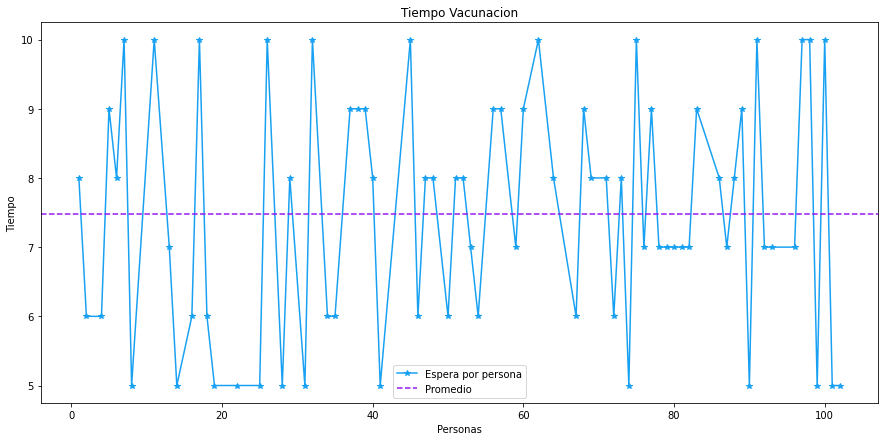

In [23]:
promedio_vacunacion={}
for i in list(tiempo_vacunacion_final.keys()):
    #print(i.split('-'))
    promedio_vacunacion[int(i.split('-')[1])]=tiempo_vacunacion_final[i]
promedio_vacunacion=dict(sorted(promedio_vacunacion.items()))

plt.figure(figsize = (15,7))
plt.plot(promedio_vacunacion.keys(), promedio_vacunacion.values(),'*-', color='#18A1F2')
plt.axhline(y=sum(list(tiempo_vacunacion_final.values()))/len(tiempo_vacunacion_final), xmin=0.0, xmax=1,color='#9318F2',linestyle="--")
plt.title('Tiempo Vacunacion')
plt.xlabel('Personas')
plt.ylabel('Tiempo')
plt.legend(['Espera por persona', 'Promedio'])

### Personas total

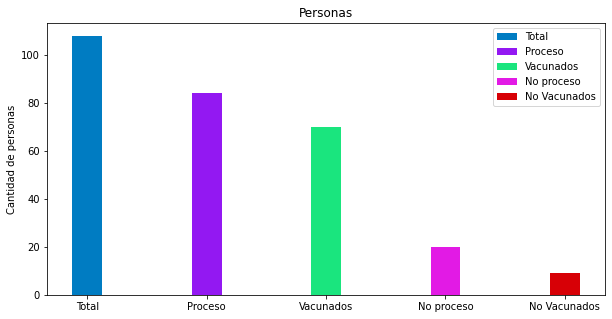

In [24]:

x = [1,2,3,4,5]

tags = ['Total','Proceso', 'Vacunados','No proceso', 'No Vacunados']

fig, ax = plt.subplots(figsize=(10,5))
bar1 = ax.bar(x[0], len(estado_personas), 0.25, label='Total', color="#007CC2")
bar2 = ax.bar(x[1], proceso, 0.25, label='Proceso', color="#9318F2")
bar3= ax.bar(x[2], vacunados, 0.25, label='Vacunados', color="#1AE57E")
bar4 = ax.bar(x[3], no_proceso, 0.25, label='No proceso', color='#E21AE5')
bar5= ax.bar(x[4], no_atendidos, 0.25, label='No Vacunados', color="#D70006")


ax.set_ylabel('Cantidad de personas')
ax.set_title('Personas')
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend(loc="upper right")

plt.show()

## Simulacion 30 dias despues para la segunda Dosis

*  En la simulacion de la primera dosis los estados de cada uno de las fases por la que pasa la persona fueron almacenados dentro de un diccionarios, mismo datos que nos serviran en esta segunda fase donde se dara preferencia a estas personas
* Las personas nuevas que lleguen en esta segunda fase, sera de la misma forma entregadas el carnet con la fecha para la segunda dosis 

In [11]:
estado_personas_segunda={}
tiempos_espera_segunda={}
personas_vacunacion_segunda={}
personas_vacunacion_segunda={}
tiempo_espera_final_segunda={}
personas_espera_segunda={}
personas_carnet_segunda={}
tiempo_vacunacion_final_segunda={}
#estado_personas={}
def llegada_personas(env, nombre, vacunacion, tiempo_vacunacion, tiempo_espera, tiempo_certificado, tipo):
    
    if tipo==1:
        if estado_personas[nombre]=='Carnet':
            print('---> Llega [%s] segunda dosis a la cola hora %.2f.'%(nombre,env.now))
            estado_personas_segunda[nombre]='ColaSegunda'
    else:
        if random.randint(1,100)>=(100-PORCENTAJE_PROCESO_ECUADOR):
            print('---> Genera [%s] a la cola hora %.2f.'%(nombre,env.now))
            estado_personas_segunda[nombre]='Cola'
        else:
            print('---> Genera [%s] hora %.2f. no realiza proceso ☠️'%(nombre,env.now))
            estado_personas_segunda[nombre]='No proceso'
        
    if random.randint(1,100)<=PORCENTAJE_NO_VACUNAR:
        print('❌'*3,'[%s] acude al proceso pero no puede vacunarse  '%(nombre),'❌'*3)
        estado_personas_segunda[nombre]='No califica'
    else:
        
        llegada=env.now
        tiempos_espera_segunda[nombre]=env.now
        with vacunacion.mesas_vacunacion.request() as mesas:
            yield mesas
            lista_cola=[key for key in list(estado_personas_segunda.keys()) if estado_personas_segunda[key]=='ColaSegunda' or estado_personas_segunda[key]=='Cola']
            for i in range(MESAS_VACUNACION):
                 if len(lista_cola)>0:
                    persona_cola=lista_cola[0]
                    if vacunacion.mesas_libres_vacunacion(i):
                        if not persona_cola in personas_vacunacion_segunda:
                            MESAS_LIBRES_VACUNACION[i]='Ocupada'
                            personas_vacunacion_segunda[persona_cola]=i
                            inicio_vacunacion=env.now
                            print('💉 La: [%s] entra a vacunarse al hora %.2f MESA %s luego de esperar  %s minutos '%(persona_cola,env.now, i+1, env.now-tiempos_espera_segunda[persona_cola]))
                            tiempo_espera_final_segunda[persona_cola]=env.now-tiempos_espera_segunda[persona_cola]
                            yield env.process(vacunacion.proceso_vacunacion(persona_cola, tiempo_vacunacion,i))
                            print('Sale de vacunarse [%s] a la hora %.2f libre MESA %s se demoro %s minutos'%(persona_cola, env.now, i+1, env.now-inicio_vacunacion))
                            tiempo_vacunacion_final_segunda[persona_cola]=env.now-inicio_vacunacion
                            estado_personas_segunda[persona_cola]='Vacunado'
                            MESAS_LIBRES_VACUNACION[i]='Libre'
                    lista_cola.remove(persona_cola)
                
            lista_vacuna=[key for key in list(estado_personas_segunda.keys()) if estado_personas_segunda[key]=='Vacunado']
            for i in lista_vacuna:
                if not i in personas_espera_segunda:
                    print('⌛ La: [%s] entra a la sala de espera al hora %.2f '%(i, env.now))
                    personas_espera_segunda[i]='espera'
                    yield env.process(vacunacion.proceso_esperar(i,tiempo_espera))
                    estado_personas_segunda[i]='Espera_Sintomas'
                    #print('**** La: [%s] sale a la sala de espera al hora %.2f '%(i, env.now))
                
            lista_espera=[key for key in list(estado_personas_segunda.keys()) if estado_personas_segunda[key]=='Espera_Sintomas']
            for i in lista_espera:
                if not i in personas_carnet_segunda:
                    personas_carnet_segunda[i]='carnet'
                    yield env.process(vacunacion.entrega_carnet(i,tiempo_certificado))
                    if i in estado_personas and tipo==1:
                        print('📝 La: [%s] recibe su carnet al hora %.2f DOSIS COMPLETA'%(i, env.now))
                        estado_personas_segunda[i]='CarnetSegunda'
                    else:
                        dia_actual='23/06/2021'
                        prox_cita = datetime.strftime(datetime.strptime(dia_actual, '%d/%m/%Y')+dt.timedelta(days=21), '%d/%m/%Y')
                        print('📝 La: [%s] recibe su carnet al hora %.2f con fecha segunda dosis  %s'%(i, env.now, prox_cita))
                        estado_personas_segunda[i]='Carnet'
                    yield env.process(vacunacion.salir_recinto())
                    print('<<--- La: [%s] abandona las instalaciones al hora %.2f '%(i, env.now))
                
        
def ejecutar_simulacion(env, mesas_vacunacion, intervalo_llegada, tiempo_vacunacion, tiempo_espera,tiempo_certificado):
    vacunacion = Vacunacion(env, mesas_vacunacion)
    vacunacion.vaciar_mesas()
    i=0
    cont=0
    for j in list(estado_personas.keys())[:COLA+20]:
        if estado_personas[list(estado_personas.keys())[i]] =='Carnet':
            env.process(llegada_personas(env,j, vacunacion,  tiempo_vacunacion, tiempo_espera, tiempo_certificado,1))
        else:
            cont+=1
        i+=1
        
    while True:
        yield env.timeout(random.randint(intervalo_llegada-2, intervalo_llegada+2))
        if i >=len(estado_personas):
            env.process(llegada_personas(env,'Persona-%d'%(cont+1), vacunacion,  tiempo_vacunacion, tiempo_espera, tiempo_certificado,0))
            cont+=1
        else:
            if estado_personas[list(estado_personas.keys())[i]] =='Carnet': 
                env.process(llegada_personas(env,list(estado_personas.keys())[i], vacunacion,  tiempo_vacunacion, tiempo_espera, tiempo_certificado,1))
                cont=int(list(estado_personas.keys())[i].split('-')[1])
        i+=1
        
random.seed(77)
env2= simpy.Environment()
env2.process(ejecutar_simulacion(env2, MESAS_VACUNACION,9, TIEMPO_VACUNACION, TIEMPO_ESPERAR_SINTOMAS, TIEMPO_CERTIFICADO))
env2.run(until=1000)

---> Llega [Persona-1] segunda dosis a la cola hora 0.00.
---> Llega [Persona-2] segunda dosis a la cola hora 0.00.
---> Llega [Persona-4] segunda dosis a la cola hora 0.00.
---> Llega [Persona-5] segunda dosis a la cola hora 0.00.
---> Llega [Persona-6] segunda dosis a la cola hora 0.00.
---> Llega [Persona-7] segunda dosis a la cola hora 0.00.
---> Llega [Persona-8] segunda dosis a la cola hora 0.00.
---> Llega [Persona-11] segunda dosis a la cola hora 0.00.
---> Llega [Persona-13] segunda dosis a la cola hora 0.00.
---> Llega [Persona-14] segunda dosis a la cola hora 0.00.
---> Llega [Persona-16] segunda dosis a la cola hora 0.00.
---> Llega [Persona-17] segunda dosis a la cola hora 0.00.
---> Llega [Persona-18] segunda dosis a la cola hora 0.00.
---> Llega [Persona-19] segunda dosis a la cola hora 0.00.
---> Llega [Persona-22] segunda dosis a la cola hora 0.00.
---> Llega [Persona-25] segunda dosis a la cola hora 0.00.
❌❌❌ [Persona-25] acude al proceso pero no puede vacunarse   ❌❌❌

### Resultados Metricas

In [12]:
vacunados_segunda=0
total=0
no_atendidos=0
no_proceso=0
personas_nuevas=0
for key in estado_personas_segunda:
    total+=1
    if estado_personas_segunda[key]=='CarnetSegunda': vacunados_segunda+=1
    if estado_personas_segunda[key]=='No califica': no_atendidos+=1
    if estado_personas_segunda[key]=='No proceso': no_proceso+=1
    if estado_personas_segunda[key]=='Carnet': personas_nuevas+=1
print('-'*70,'\n* Total personas: ', total)
print('* Personas vacunadas dosis completa: ', vacunados_segunda)
print('* Personas que no pudieron vacunarse: ', no_atendidos)
print('* Personas que no asistieron al proceso: ', no_proceso)
print('* Personas primera dosis: ', personas_nuevas)
print('* Tiempo promedio espera en la cola: ',sum(list(tiempo_espera_final_segunda.values()))/len(tiempo_espera_final_segunda))
print('* Tiempo promedio Vacunacion: ', sum(list(tiempo_vacunacion_final_segunda.values()))/len(tiempo_vacunacion_final_segunda),'\n','-'*70)

---------------------------------------------------------------------- 
* Total personas:  121
* Personas vacunadas dosis completa:  60
* Personas que no pudieron vacunarse:  13
* Personas que no asistieron al proceso:  7
* Personas primera dosis:  39
* Tiempo promedio espera en la cola:  11.564356435643564
* Tiempo promedio Vacunacion:  7.683168316831683 
 ----------------------------------------------------------------------


## Graficas Segunda Dosis

### Tiempo espera en la cola

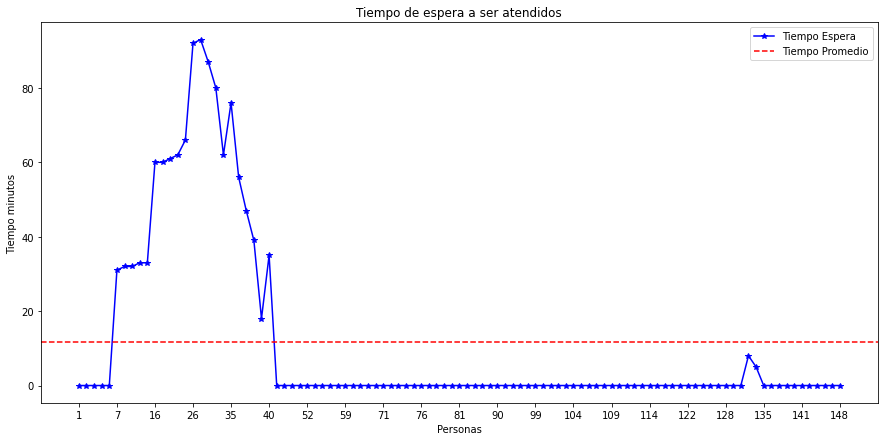

In [13]:
promedio={}
for i in list(tiempo_espera_final_segunda.keys()):
    #print(i.split('-'))
    promedio[i.split('-')[1]]=tiempo_espera_final_segunda[i]


plt.figure(figsize = (15,7))
plt.plot(list(promedio.keys()),list(promedio.values()),'*-b')
plt.xticks(list(promedio.keys())[::5])
plt.axhline(y=sum(list(tiempo_espera_final_segunda.values()))/len(tiempo_espera_final_segunda), xmin=0.0, xmax=1,color='red',linestyle="--")

plt.title('Tiempo de espera a ser atendidos')
plt.xlabel('Personas')
plt.ylabel('Tiempo minutos')
plt.legend(['Tiempo Espera','Tiempo Promedio'])

### Tiempo Vacunacion

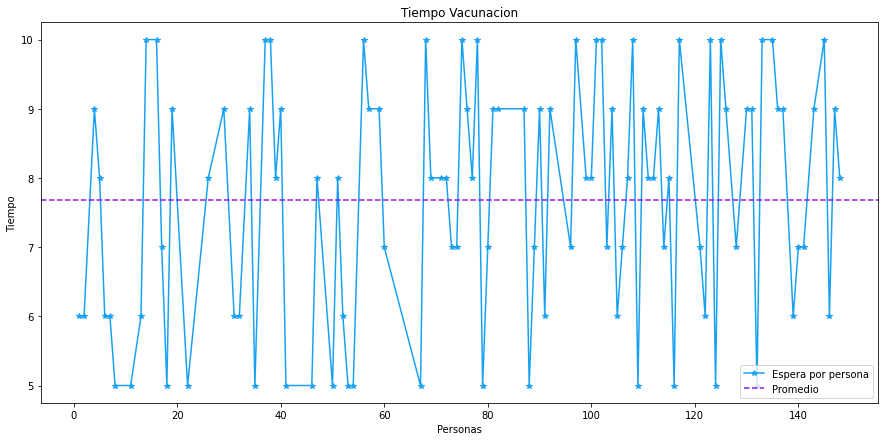

In [14]:
promedio_vacunacion={}
for i in list(tiempo_vacunacion_final_segunda.keys()):
    #print(i.split('-'))
    promedio_vacunacion[int(i.split('-')[1])]=tiempo_vacunacion_final_segunda[i]
promedio_vacunacion=dict(sorted(promedio_vacunacion.items()))

plt.figure(figsize = (15,7))
plt.plot(promedio_vacunacion.keys(), promedio_vacunacion.values(),'*-', color='#18A1F2')
plt.axhline(y=sum(list(tiempo_vacunacion_final_segunda.values()))/len(tiempo_vacunacion_final_segunda), xmin=0.0, xmax=1,color='#9318F2',linestyle="--")
plt.title('Tiempo Vacunacion')
plt.xlabel('Personas')
plt.ylabel('Tiempo')
plt.legend(['Espera por persona', 'Promedio'])

### Personas Total

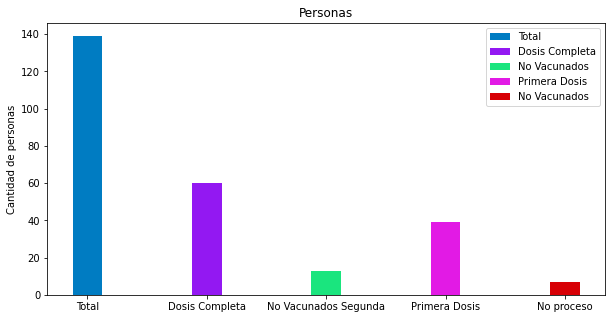

In [15]:
x = [1,2,3,4,5]

tags = ['Total', 'Dosis Completa','No Vacunados Segunda','Primera Dosis','No proceso']

fig, ax = plt.subplots(figsize=(10,5))
bar1 = ax.bar(x[0], len(estado_personas), 0.25, label='Total', color="#007CC2")
bar2 = ax.bar(x[1], vacunados_segunda, 0.25, label='Dosis Completa', color="#9318F2")
bar3= ax.bar(x[2], no_atendidos, 0.25, label='No Vacunados', color="#1AE57E")
bar4 = ax.bar(x[3], personas_nuevas, 0.25, label='Primera Dosis', color='#E21AE5')
bar5= ax.bar(x[4], no_proceso, 0.25, label='No Vacunados', color="#D70006")


ax.set_ylabel('Cantidad de personas')
ax.set_title('Personas')
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend(loc="upper right")
